In [1]:
# General stuff
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.patches import Circle, Ellipse, Rectangle
import seaborn as sns

# Astropy stuff
from astropy.io import fits, ascii
from astropy.visualization import simple_norm  # this will come in handy to visualize images
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import table
import astropy.units as u

# For calculating flux
import sep

# Fitting stuff
from scipy import stats
from scipy.optimize import curve_fit
import General_functions as my

# For convolving
import warnings
from astropy.modeling.models import Sersic2D
from scipy.signal import fftconvolve as fft

# For creating loading bars
from tqdm.notebook import tqdm

# Import datasets, classifiers and performance metrics
from sklearn import datasets, manifold, metrics, preprocessing, utils
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy.spatial.distance import cdist

# Load tables and images

In [2]:
# Opening the IRAC ch1 image
def open_img(filename, hdu=0):
    
    if filename[-5:] == '.fits':  
        # if last 5 characters of the string are '.fits', the file is interpreted as FITS file
        hdul = fits.open(filename)  # open the HDU list of a FITS file 
                                    # (it may contain multiple data sets called Header Data Units)
            
        img = hdul[hdu].data  # save data from the unit n. 1 (or whatever is the `hdu` nuber) into `img` array
        hdr = hdul[hdu].header  # we may need also the header, which contain info about the image/data set
        # .header
        hdul.close()  # close the FITS file
        
    else:
        # if not FITS file, the function complains because it doesn't know other ways to do
        sys.exit("ERROR: open_img can deal with FITS file only.")
        
    return img, hdr  # the output is a tuple of two different objects

In [3]:
# Load IRAC ch1 image and residual image from ch1 + ch2
img, hdr = open_img('Resources/IRAC_ch1.fits', hdu=0)

In [4]:
# Load COSMOS catalogue
cosmos_tab = table.Table.read("Resources/COSMOS2020_CLASSIC_v1.5_formatted.fits",format="fits")

In [5]:
# Load residual catalogue
resi_tab = table.Table.read('Resources/irac-resid_v2_comb.fits', format='fits')

In [6]:
# Load catalogue with labels
labels_tab = table.Table.read('Resources/irac-resid_v2_visual-class.fits', format='fits')

# Plot a few objects, IRAC image and different vignettes
First we need to match coordinates of the cosmos_tab (to find objects in IRAC) with coordinates of resi_tab

In [7]:
#Sky matching function (adjusted so my_skycoord should be a SkyCoord class)
def match_cat(my_coord, cat_coord, r=1):

    # SkyCoord eats numbers with units.
    # This function assumes input coordinates are in decimal degree
    import astropy.units as u
    my_skycoord = SkyCoord(ra = my_coord[0], dec = my_coord[1], unit='deg')
    cat_skycoord = SkyCoord(ra = cat_coord[0], dec = cat_coord[1], unit='deg')
    
    idx, d2d, _ = match_coordinates_sky(my_skycoord, cat_skycoord)
    max_sep = r*u.arcsec
    sep_limit = d2d < max_sep
    #sep_limit not only the mask for selecting objects within the 2nd sample, but by itself can be used to select in the 1st sample.
    return sep_limit, idx[sep_limit]

We make sure that the coordinates from the catalogue are actually within the tile we are working with

In [8]:
# Load information from the tile's header
w = WCS(hdr)

# corner values on shape [y,x] for img
y_lim, x_lim = np.shape(img)

# Find pixel values in the image's corner (notice this is on the form x,y as in DS9 and not like imshow shows)
bottom_left = (11,11)
bottom_right = (x_lim-11, 11)
upper_left = (11, y_lim-11)
upper_right = (x_lim-11, y_lim-11) # We remove 11 pixels from border so we can always make 21x21 size cutouts

# Find RA DEC coordinates for these
corners = [bottom_left, bottom_right, upper_left, upper_right]
sky_corners = []

for i in range(4):
    skycoord = w.pixel_to_world(*corners[i])
    print(skycoord)
    sky_corners.append(skycoord) 

<SkyCoord (ICRS): (ra, dec) in deg
    (151.0623357, 1.29133181)>
<SkyCoord (ICRS): (ra, dec) in deg
    (149.05920166, 1.29128805)>
<SkyCoord (ICRS): (ra, dec) in deg
    (151.0636075, 3.29393279)>
<SkyCoord (ICRS): (ra, dec) in deg
    (149.05778055, 3.29382107)>


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [9]:
# The interval of right ascension is thus:
ra_int = (149.05920166, 151.0623357)

# Declination interval
dec_int = (1.29133181, 3.29393279) #change later

# Lets mask the cosmos catalogue to create a new catalogue containing only sources within the image
mask = (cosmos_tab['ALPHA_J2000'] > ra_int[0]) & (cosmos_tab['ALPHA_J2000'] < ra_int[1]) \
        & (cosmos_tab['DELTA_J2000'] > dec_int[0]) & (cosmos_tab['DELTA_J2000'] < dec_int[1])
match_cosmos = cosmos_tab[mask]

In [10]:
# Extract coordinates RA, DEC
cosmos_coord = [ match_cosmos['ALPHA_J2000'], match_cosmos['DELTA_J2000'] ] #no coordinates specific for IRAC in tab
resi_coord = [ resi_tab['ALPHA_J2000'], resi_tab['DELTA_J2000'] ] #same

# Get indices of matching objects
resi_idx, cosmos_idx = match_cat(resi_coord, cosmos_coord)

# Print number of matched objects
print('No. of matched objects:', np.sum(resi_idx))

No. of matched objects: 653


# Load t-SNE embedding from the other notebook

In [12]:
# Save the embedding so we dont have to run it again
import pickle
with open('Saved_Results/embedding.pickle', 'rb') as f:
    X_tsne_arr = pickle.load(f)

In [13]:
np.shape(X_tsne_arr)

(9, 3139, 2)

This is the right size, there was 9 different perplextities used therefor there are 9 embedding stored. Each with 3139 samples with 2 coordinates.

## Labeling color with blue and red udefined color marked separetly

In the previous notebook we calculated the colors and plotted them. In case we need to use that later, lets save the color arrays here.

In [14]:
# Define colors myself
uvista = 30
irac = 21.58

# Calculate magnitudes in each band
mag_H =  -2.5*np.log10(resi_tab['FLUX_APER_H'][:,0]) + uvista
mag_Ks = -2.5*np.log10(resi_tab['FLUX_APER_Ks'][:,0]) + uvista
mag_ch1 = -2.5*np.log10(resi_tab['FLUX_APER_ch1'][:,0]) + irac
mag_ch2 = -2.5*np.log10(resi_tab['FLUX_APER_ch2'][:,0]) + irac

# Calculate colors (including Nan, we will plot over these anyways)
H_Ks = mag_H - mag_Ks
Ks_ch1 = mag_Ks - mag_ch1
ch1_ch2 = mag_ch2 - mag_ch1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


# Choosing perplexity 40 and labeling (i) Robust candidates, (ii) Matched objects and (iii) Bright objects

Lets make a plot visualising the embedding while marking 3 regions, from which we can show examples of cutouts. First we will extract the t-SNE coordinates belonging to perplexity 40, afterwards we need to make masks that can extract the objects from the different regions. Bright objects are nicely seperated and therefor doesnt have to be found from a requirement on the flux in the catalogue although we can select them from the embedding and report the minimum flux present in the group.

In [15]:
# Extract the embedding of perplexity 40 from the array of all embeddings
X_tsne = X_tsne_arr[5]

In [16]:
# Create figure
fig = plt.figure(figsize=(9, 6))
plt.subplots_adjust(wspace= 0.25, hspace= 0.25)




<Figure size 648x432 with 0 Axes>

## Labeling matched objects

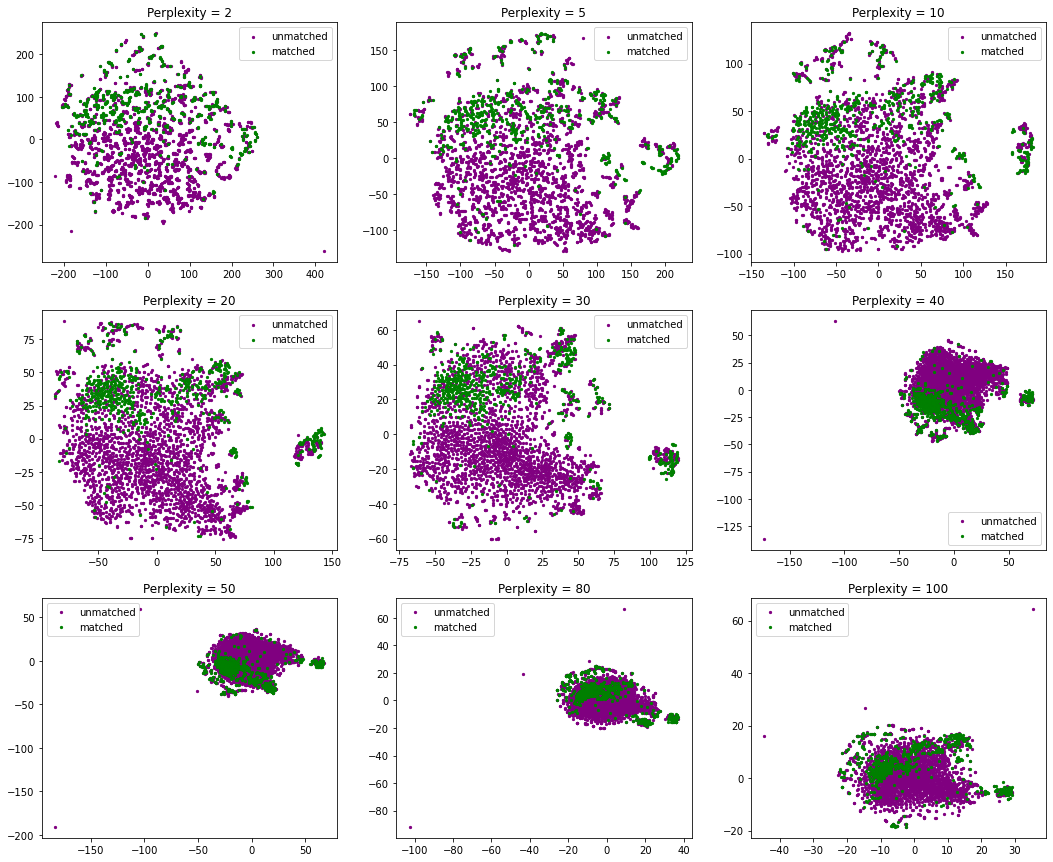

In [28]:
# Plot matched and unmatched objects
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(18,15))
ax = ax.flatten()

for i in range(len(perplexities)):

    ax[i].scatter(X_tsne_arr[i][:,0][~resi_idx], X_tsne_arr[i][:,1][~resi_idx], c='purple', s=5, label='unmatched')
    ax[i].scatter(X_tsne_arr[i][:,0][resi_idx], X_tsne_arr[i][:,1][resi_idx], c='green', s=5, label='matched')
    ax[i].set_title(f'Perplexity = {perplexities[i]}')
    ax[i].legend()

plt.show()

## Labeling the robust candidades

In [29]:
# Select all objects in resi_tab that are labelled "O" in the NOTES column in labels_tab
O_mask = (labels_tab['NOTES']=='O ')

# Extract the numbers from the list
O_numbers = labels_tab[O_mask]['NUMBER']
print(f'There are {len(O_numbers)} galaxies denoted O: the most interesting ones for our purpose')

# Make a mask for the resi_tab that is 1 (True) for 'O' and 0 (False) for the rest
O_resi_mask = np.zeros(len(resi_tab), dtype=bool)

for i in range(len(resi_tab)):
    
    if resi_tab['NUMBER'][i] in O_numbers:
        O_resi_mask[i] = int(1)
    
    else:
        O_resi_mask[i] = int(0)

# Check it worked
np.sum(O_resi_mask)

There are 62 galaxies denoted O: the most interesting ones for our purpose


62

In [30]:
# Do the same for K
K_mask = (labels_tab['NOTES']=='K ')

# Extract the numbers from the list
K_numbers = labels_tab[K_mask]['NUMBER']
print(f'There are {len(K_numbers)} galaxies denoted K: the next interesting ones for our purpose')

# Make a mask for the resi_tab that is 1 (True) for 'O' and 0 (False) for the rest
K_resi_mask = np.zeros(len(resi_tab), dtype=bool)

for i in range(len(resi_tab)):
    
    if resi_tab['NUMBER'][i] in K_numbers:
        K_resi_mask[i] = True
    
    else:
        K_resi_mask[i] = False

# Check it worked
np.sum(K_resi_mask)

There are 71 galaxies denoted K: the next interesting ones for our purpose


71

In [31]:
# Make a mask that is neither O nor K
other_resi_mask_inv = O_resi_mask + K_resi_mask #remember this has to be inverted

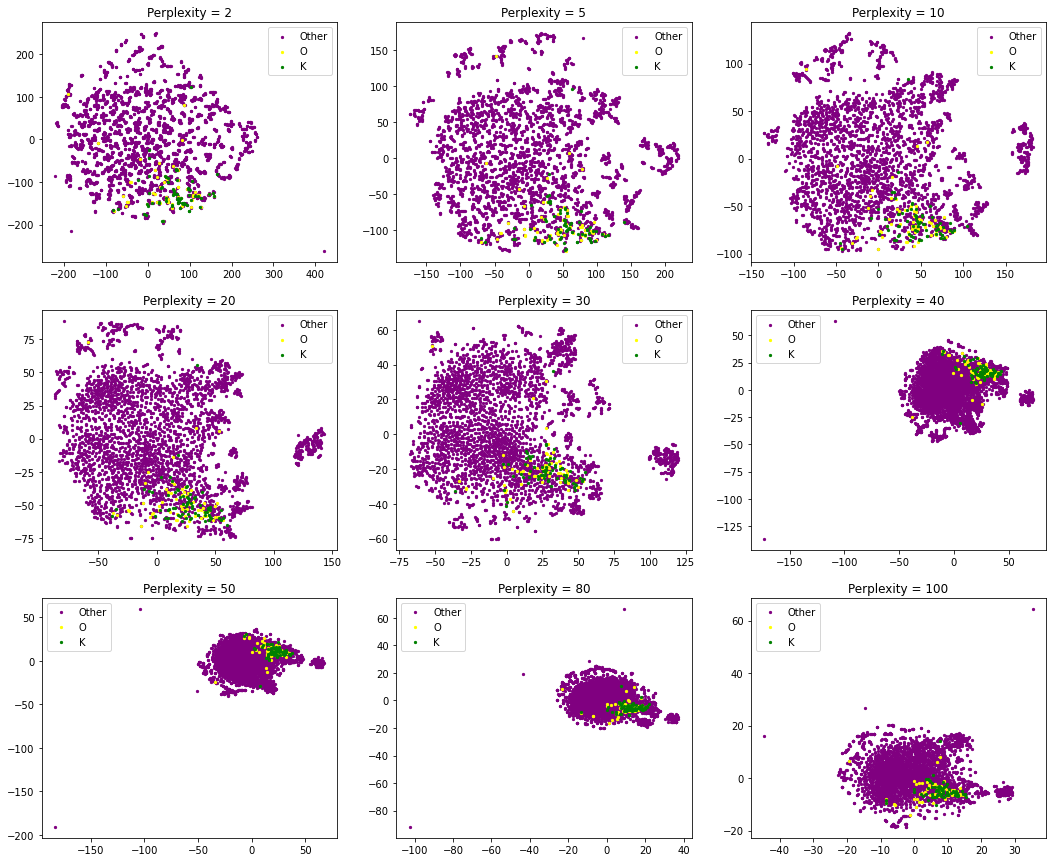

In [32]:
# Plot it for all perplexities

# Plot matched and unmatched objects
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(18,15))
ax = ax.flatten()

for i in range(len(perplexities)):
    
    ax[i].scatter(X_tsne_arr[i][:,0][~other_resi_mask_inv], X_tsne_arr[i][:,1][~other_resi_mask_inv], 
                  c='purple', s=5, label='Other')
    ax[i].scatter(X_tsne_arr[i][:,0][O_resi_mask], X_tsne_arr[i][:,1][O_resi_mask], 
                  c='yellow', s=5, label='O')
    ax[i].scatter(X_tsne_arr[i][:,0][K_resi_mask], X_tsne_arr[i][:,1][K_resi_mask], 
                  c='green', s=5, label='K')
    ax[i].legend()
    ax[i].set_title(f'Perplexity = {perplexities[i]}')

plt.show()

# Choose perplexity 40 and make predictions from half of the labels

In [33]:
# Define the cut that uses only half of the labels available
O_cut, K_cut = np.sum(O_resi_mask)//2, np.sum(K_resi_mask)//2
print(O_cut, K_cut)

31 35


In [34]:
# Check manually where we can cut the mask (and fill in zeros for the rest) to obtain the number above
print(np.sum(O_resi_mask[:1100]), np.sum(K_resi_mask[:1000]))

31 35


In [35]:
# Make a new mask from the cuts
O_resi_mask_new = O_resi_mask.copy()
O_resi_mask_new[1100:] = 0

K_resi_mask_new = K_resi_mask.copy()
K_resi_mask_new[1000:] = 0

# Make a mask that is neither O nor K
other_resi_mask_new_inv = O_resi_mask_new + K_resi_mask_new #remember this has to be inverted

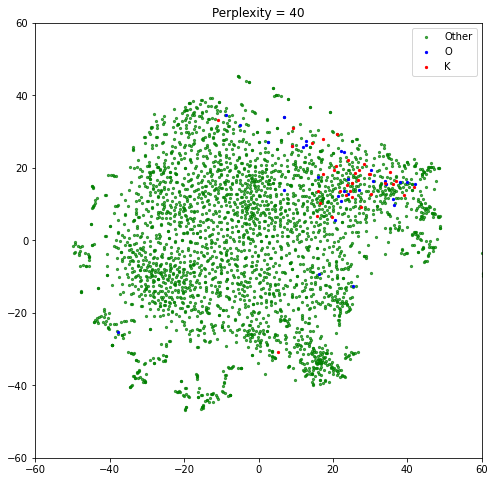

In [36]:
# Lets zoom in on the 40 perplexity and use only half of the labels O and K
fig, ax = plt.subplots(figsize=(8,8))
    
ax.scatter(X_tsne[:,0][~other_resi_mask_new_inv], X_tsne[:,1][~other_resi_mask_new_inv], 
                  c='green', s=5, label='Other',zorder=1,alpha=0.7)
ax.scatter(X_tsne[:,0][O_resi_mask_new], X_tsne[:,1][O_resi_mask_new], 
                  c='blue', s=5, label='O',zorder=2)
ax.scatter(X_tsne[:,0][K_resi_mask_new], X_tsne[:,1][K_resi_mask_new], 
                  c='red', s=5, label='K',zorder=3)
ax.legend()
ax.set_title(f'Perplexity = 40')
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)

plt.show()

Now we need to make some predictions from the labels we do have. In Charles' paper they used K voting (or something like that the algortihm is not completely described but let's try doing something similar). They write that:

Objects in the test sample are therefore classified as quiescent when the quiescent fraction of m neighboring training galaxies is fQ > fmin. A natural choice of fmin might seem to be 0.5, letting a majority of nearby objects determines the label. However, in practice the optimal choice depends upon how many objects are scattered via measurement errors to incorrectly be close neighbors. Therefore, the optimal choice of fmin depends upon a combination of uncer- tainties and the underlying true fraction of quiescent galaxies in the training sample. The choice of fmin also depends upon the desired relationship between quantity and quality in the resulting catalog; a higher value of fmin will result in fewer false positives but more false negatives.

I will try to define a function that does something like this, using an fmin of 0.5 to start with. We will apply this method to the remaining half of the labelled sample, so we can compute a ROC curve afterwards to analyse the result. One can either try an algorithm based on the nearest K neighbours voting or the voting of all neighbours within a predefined radius (this is better for non-uniformly distributed data) - lets try both and compare them

A problem we face is that we only have labels for promising candidades and not for non-promising candidades. Perhaps a work around is saying that say if there are 3 promising candidates wihtin a small radius of the point, we should label it as promising itself.

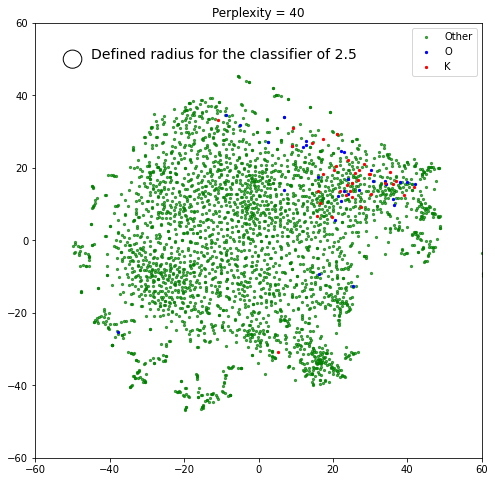

In [37]:
# Define how big a radius we will use (going with the latter suggested work around)
radius = 2.5

fig, ax = plt.subplots(figsize=(8,8))
    
ax.scatter(X_tsne[:,0][~other_resi_mask_new_inv], X_tsne[:,1][~other_resi_mask_new_inv], 
                  c='green', s=5, label='Other',zorder=1,alpha=0.7)
ax.scatter(X_tsne[:,0][O_resi_mask_new], X_tsne[:,1][O_resi_mask_new], 
                  c='blue', s=5, label='O',zorder=2)
ax.scatter(X_tsne[:,0][K_resi_mask_new], X_tsne[:,1][K_resi_mask_new], 
                  c='red', s=5, label='K',zorder=3)

# Make circle
circ = Circle((-50, 50), radius, color='k', fill=False)
ax.add_patch(circ)
ax.text(-45,50, f'Defined radius for the classifier of {radius}', fontsize=14)

ax.legend()
ax.set_title(f'Perplexity = 40')
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)

plt.show()

To make this classification we need a few things:

- (1) an array with only the labelled data (good sample)
- (2) an array with the labelled data that we have masked (those we want to classify)
- (3) an array with all other points so we can visualise the clustering afterwards for all points

Array (1) will be called the train sample since we will use this as the basis of our classification.
Arrays (2) and (3) will be combined, so we can make predictions, classify all of them, and we will use the predictions on array (2) together with the actual label (all promising candidates thus all 1) as our validation set.

We will need a function that takes the unknown sample (2) and (3) and for each point in that sample calculate the distance to all points in the good sample (1). If the point we evaluate which distance to at least 1 promising candidate, from (1), is smaller than a specified radius we will classify it with 1 (a promising candidate).

In [38]:
# Test that the distance metric works
test_point = np.array([[1,2]])
dist_points = np.array([[3,4],[5,6]])
print(f'Shapes are: {np.shape(test_point)}, {np.shape(dist_points)}')

dist = cdist(test_point, dist_points)
dist

Shapes are: (1, 2), (2, 2)


array([[2.82842712, 5.65685425]])

In [39]:
# Lets create the arrays we need (1), (2) and (3) and check their shapes

# Array (1) only known labeled data --------------------------------------------------------
train = X_tsne[O_resi_mask_new+K_resi_mask_new]
print(f'Shape of train: {np.shape(train)}')

# Array (2) only unknown labeled data ------------------------------------------------------

# Make a new mask from the cuts (separating the other part of the data)
O_resi_val_mask = O_resi_mask.copy()
O_resi_val_mask[:1100] = 0

K_resi_val_mask = K_resi_mask.copy()
K_resi_val_mask[:1000] = 0

val = X_tsne[O_resi_val_mask+K_resi_val_mask]
print(f'Shape of val: {np.shape(val)}')

# Array (3) the rest, all unlabeled data ---------------------------------------------------
unknown = X_tsne[~(O_resi_mask+K_resi_mask)]
print(f'Shape of unknown: {np.shape(unknown)}')

# Put array (2) and (3) together to form the points to be labeled
test = np.row_stack((val,unknown))
print(f'Shape of val and unknown put together (test): {np.shape(test)}')


# Check that it all sums to the right number of total samples
print(f'All samples: {len(resi_tab)}')
print(f'Sum of all arrays: {len(train)+len(test)}')

Shape of train: (66, 2)
Shape of val: (67, 2)
Shape of unknown: (3006, 2)
Shape of val and unknown put together (test): (3073, 2)
All samples: 3139
Sum of all arrays: 3139


In [40]:
# Attempting to make a function that classifies
def classifier(good_sample, unknown_sample, radius, k):
    """
    Good sample: the coordinates of the sample labeled O and K
    Unknown sample: all unlabled candidates
    Radius: the radius to look within
    k: number of good samples needed within the radius to classify the point as promising
    ------
    Function will find all points wihtin the radius of the current sample point and asses whether there 
    are k points from the good sample in there. If there is it will label a promising candidate 1, if not
    it will label it 0, a bad candidate.
    """
    
    # Make empty array for storing the labels of the unknown sample
    labels = np.zeros(len(unknown_sample), dtype=bool)
    
    # Loop over all unknown points
    for i in range(len(unknown_sample)):
        
        # Calculate distance to all good samples
        d = cdist( np.array([ [test[i][0],test[i][1]] ]), good_sample)
        
        # Find how many distances are smaller than the radius
        count = np.sum(d <= radius)
        
        # Evaluate if the count is above or equal to the minimum number k - assign labels accordingly
        if count < k:
            labels[i] = 0
            
        if count >= k:
            labels[i] = 1
            
    return labels

In [41]:
# Perform the classification
all_labels = classifier(train, test, 2.5, 1)

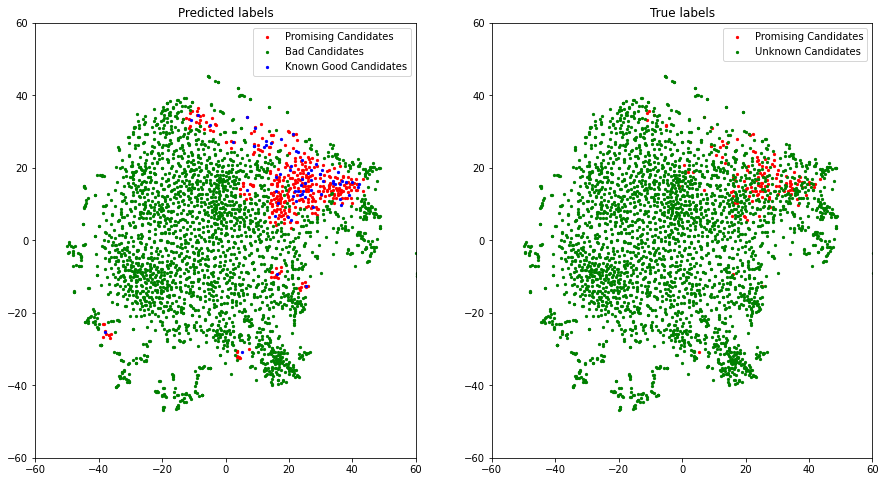

In [42]:
# Plot the results of classification along with the ground truth

fig, ax = plt.subplots(ncols=2, figsize=(15,8))
    
ax[0].scatter( test[:,0][all_labels], test[:,1][all_labels], c='r', s=5, label='Promising Candidates')
ax[0].scatter( test[:,0][~all_labels], test[:,1][~all_labels], c='g', s=5, label='Bad Candidates')
ax[0].scatter( train[:,0], train[:,1], c='b', s=5, label='Known Good Candidates' )

ax[0].legend()
ax[0].set_title('Predicted labels')
ax[0].set_xlim(-60,60)
ax[0].set_ylim(-60,60)

ax[1].scatter( X_tsne[:,0][O_resi_mask+K_resi_mask], X_tsne[:,1][O_resi_mask+K_resi_mask], 
              c='r', s=5, label='Promising Candidates')
ax[1].scatter( unknown[:,0], unknown[:,1], c='g', s=5, label='Unknown Candidates')

ax[1].legend()
ax[1].set_title('True labels')
ax[1].set_xlim(-60,60)
ax[1].set_ylim(-60,60)


plt.show()


We cant produce a ROC curve since we have no points labelled as bad candidates, again we should look into this. Instead we can compute a accuracy.
Accuracy = (TP + TN) / (TP + TN + FP + FN)

In [43]:
# Get predicted and true labels of the validation set
val_pred_labels = all_labels[:len(val)]
val_true_labels = np.ones(len(val))

# Calculate accuracy
TP = np.sum(val_pred_labels)
FN = np.sum(~val_pred_labels)

# Since all other are 0
acc = TP / (TP+FN)
acc

0.8507462686567164

# Predictions with K voting

with the method above we were not able to produce a ROC cure or use K voting since we only have labels for promising candidates and thus no true negatives that feeds into the false positive rate and no tru negatives that could vote the other way. When visually inspecting the sources and providing labels, the worst candidates simply were not included in the table. Therefor we will now labels the bad candidates as those that were not included in the labels from visual inspection.

There will likely be more bad candidates than good ones so we will have to balance their voting somehow. Again we will use only half of the labels or so to make the voting (training) and the other half to validate and produce the roc curve as well as providing an estimate for the accuracy. There are two ways to do this:
1) letting the K nearest neighbour vote. This is likely more suited for a t-SNE plot that is in reality a hyperdimensional manifold where the euclidean distance is not necessarily the same in different regions of the embedding. This is similar to when you project a sphere onto a plane as we do with a world map, some continent will apear bigger than they actually are and some smaller. Using only the nearest neighbours will account for this. It does however need an assumption that our points is uniformly distributed (in the hyperplane), while this is not necessarily true, we do have a large representative sample so it should be an okay approximation. <br>
2) letting all neighbours within a radius r vote. Somewhat similar to what we did above.

## Prepare data

In [44]:
# First find all the bad candidates i.e. those not in labels_tab
print(f'We will labels {len(resi_tab) - len(labels_tab)} as bad candidates')

bad_mask_all = np.zeros(len(resi_tab), dtype=bool)

for i in range(len(resi_tab)):
    
    if resi_tab['NUMBER'][i] not in labels_tab['NUMBER']:
        bad_mask_all[i] = 1
    else:
        bad_mask_all[i] = 0
        
bad_objects_all = resi_tab[bad_mask_all]

print(f'We found {len(bad_objects_all)} bad candidates')

We will labels 2948 as bad candidates
We found 2948 bad candidates


In [45]:
# Put all good objects in one array
good_mask_all = O_resi_mask + K_resi_mask
good_objects_all = resi_tab[good_mask_all]
print(f'We found {len(good_objects_all)} good candidates')

We found 133 good candidates


In [46]:
# Put all unlabelled data points in one array
unknown_mask_inv = bad_mask_all + good_mask_all
unknown_mask = ~unknown_mask_inv
unknown_objects = resi_tab[unknown_mask]
print(f'We found {len(unknown_objects)} unlabelled candidates')

We found 58 unlabelled candidates


In [47]:
#make sure it sums up to the correct number of candidates
print(f'There is a total of {len(resi_tab)} objects')
print(f'We have found {len(bad_objects_all)+len(good_objects_all)+len(unknown_objects)} objects')

There is a total of 3139 objects
We have found 3139 objects


NameError: name 'good_mask' is not defined

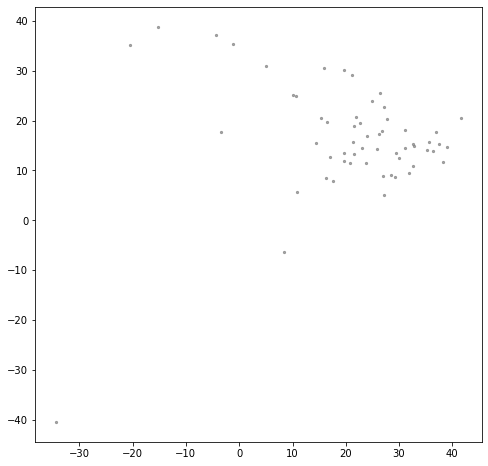

In [48]:
# Visualise the embedding with good and bad candidates
# Lets zoom in on the 40 perplexity and use only half of the labels O and K
fig, ax = plt.subplots(figsize=(8,8))
    
ax.scatter(X_tsne[:,0][unknown_mask], X_tsne[:,1][unknown_mask], 
                  c='grey', s=5, label='Unknown',zorder=1,alpha=0.7)
ax.scatter(X_tsne[:,0][good_mask], X_tsne[:,1][good_mask], 
                  c='green', s=5, label='Good',zorder=2)
ax.scatter(X_tsne[:,0][bad_mask], X_tsne[:,1][bad_mask], 
                  c='red', s=5, label='Bad',zorder=3)
ax.legend()
ax.set_title(f'Perplexity = 40')
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)

plt.show()

Clearly we have way more bad candidates than good here, and a very small unknown sample (that is actually labelled just other than O and K). Since we have 133 good candidates, then lets go for a similar sample size of bad candidates, and let the rest be unknown that we will label with our algorithm.

We will make a dataframe containing all the information we need to perform the semisupervised classification. Each row will be an object in the residual tab, the columns will contain:
- x1: first coordinate in the tsne embedding
- x2: second coordinate
- Train_labels: labels that the algortihm will make its predictions from. Good objects are assigned 1, bad candidates 0, and unknown for the algorithm is assigned -1 (this includes the ones that are actually labelled that is used for the validation). Those assigned 0 and 1 here will be allowed to vote in the algortihm.
- Val_labels: labels that we will compare with the predictions and calculate accuracy score from and produce a ROC curve. Again we use 1, 0 and -1 (here -1 )

A Problem is that we have way more bad candidates than good candidates, which will lead to problems in the voting. This can be solved in two ways:
- We can assign weights to the voting. Say we have ten times more bad candidates than good candidates, then the vote of the good ones should be weighted with 10 and the vote of the bad ones weighted with 1.
- We can make a random sampling of the bad candidates aiming to use 133 bad candidates, but it might fluctuate a bit due to the randomness. Thus the probability that we use a bad candidate in our voting should be 133/2948 = len(good)/len(bad), and the probability that we not use it is thus 1-133/2948.
We will use the latter since if we assign weights we should determine a way to define the weightss and justify why we use that. This adds another layer of abstraction, and we would like the simplest solution since this would be the more general. The problem really is that when the visual inspection providing the labels was made, this technique of using them was not kept in mind. Ideally during the visual inspection we would classify the worst candidates, and the best candidates more balanced.

To make the dataframe we first need to determine the train_labels and the val_labels. Afterwards we can combine them all in a pandas dataframe.

In [ ]:
# Set a random seed, so the results are reproducible
np.random.seed(1)

# Select a random sample of bad objects (a mask the size of the resiudal tab) 
#that continues labelled if i=True
prob = 800/len(bad_objects_all) #len(good_objects_all)/len(bad_objects_all)

bad_mask_sample = np.zeros(len(resi_tab), dtype=bool)
temp_mask = np.random.choice([True, False], size=np.sum(bad_mask_all), p=[prob,1-prob])
count = -1

for i in range(len(bad_mask_sample)):
    
    if bad_mask_all[i] == 1:
        count += 1
    
        if temp_mask[count] == 1:
            bad_mask_sample[i] = 1
            
# Specify ratio of train/val
train_size = 0.8
val_size = 1 - train_size
        
# Make masks that divides the bad sample into train and val (a mask the size of resi_tab)
bad_train = np.zeros(len(resi_tab), dtype=bool)
bad_val = np.zeros(len(resi_tab), dtype=bool)
temp_mask = np.random.choice([True,False], size=np.sum(bad_mask_sample), p=[0.97, 0.03])
count = -1

for i in range(len(bad_train)):
    
    if bad_mask_sample[i] == 1:
        count += 1
        
        if temp_mask[count] == 1:
            bad_train[i] = 1
            
        if temp_mask[count] == 0:
            bad_val[i] = 1
            

# Do the same for the good sample
good_train = np.zeros(len(resi_tab), dtype=bool)
good_val = np.zeros(len(resi_tab), dtype=bool)
temp_mask = np.random.choice([True, False], size=np.sum(good_mask_all), p=[train_size, val_size])
count = -1

for i in range(len(good_train)):
    
    if good_mask_all[i] == 1:
        count += 1
        
        if temp_mask[count] == 1:
            good_train[i] = 1
            
        if temp_mask[count] == 0:
            good_val[i] = 1
            
# Check lengths
print(f'We have {np.sum(bad_mask_sample)} bad objects and {np.sum(good_mask_all)} good objects in total')
print(f'Bad sample: {np.sum(bad_train)} is used for training, and {np.sum(bad_val)} is used for val')
print(f'Good sample: {np.sum(good_train)} is used for training, and {np.sum(good_val)} is used for val')

In [ ]:
# Lets combine the information to make the train labels
train_lbl = -1*np.ones(len(resi_tab))
train_lbl[good_train] = 1
train_lbl[bad_train] = 0

# Same for val labels
val_lbl = -1*np.ones(len(resi_tab))
val_lbl[good_val] = 1
val_lbl[bad_val] = 0

# Lets crete the dataframe that contains all information
data = pd.DataFrame(np.column_stack((X_tsne, train_lbl, val_lbl)), 
                    columns=['x1','x2','Train_labels', 'Val_labels'], index=resi_tab['NUMBER'])

data

In [ ]:
# Visualise the embedding with the training set of good and bad candidates

fig, ax = plt.subplots(figsize=(8,8))
    
ax.scatter(data['x1'][data['Train_labels']==-1], data['x2'][data['Train_labels']==-1],
          c = 'grey', s=5, label='Unknown') 

ax.scatter(data['x1'][data['Train_labels']==1], data['x2'][data['Train_labels']==1],
          c = 'green', s=10, label='Good Candidates') 

ax.scatter(data['x1'][data['Train_labels']==0], data['x2'][data['Train_labels']==0],
          c = 'red', s=10, label='Bad Candidates') 
    
ax.legend()
ax.set_title(f'Training labels included')
ax.set_xlim(-60,60)
ax.set_ylim(-60,60)

plt.show()

## Defining the classification algorithm

In [ ]:
def kNN_voting(k, dataframe):
    """
    k = int, number of nearest neighbours allowed to vote on the prediction, should be an odd number
    
    ----- updated to data containing all
    coords = array (n_samples, 2) containing the coordinates of the embedding for each point
    labels = labels of the provided number. 2 class prediction = 1 or 0. If the label is -1, 
             the point is unknown and will produce a prediction
    ----
    
    returns = array with predictions, len = number of labels==-1
    """
    
    # Number of unknown points
    n_unknown = np.sum(dataframe['Train_labels']==-1)
    
    # Make empty array for storing the class predictions on the unknown sample
    predictions = np.zeros(n_unknown)
    
    # Make empty array for storing the class predictions on what is the validation sample
    val_mask = (dataframe['Val_labels']!=-1)
    val_predictions = np.zeros(np.sum(val_mask))
    
    # Calculate distance from all unknown objects to all labeled objects (each row=one unknown point)
    d = cdist( dataframe.iloc[:,:2][data['Train_labels']==-1], 
               dataframe.iloc[:,:2][data['Train_labels']!=-1])
    
    count = -1
    
    # Loop over all unknown points
    for i in range(n_unknown):
        
        # Get the distances from the unknown point
        distances = d[i]
        
        # Get the sorted distance indexes, smallest to biggest distance
        sorted_idx = np.argsort(distances)
        
        # Get the indices of the k nearest neighbours
        neighbour_idx = sorted_idx[:k]
        
        # Get the labels of the k nearest labelled objects
        nearest_neighbours = data['Train_labels'][data['Train_labels']!=-1].to_numpy()[neighbour_idx]
        
        # Count the votes (remember bad are zero and 1 is good)
        n_good_votes = np.sum(nearest_neighbours)
        n_bad_votes = k-n_good_votes
        
        # Save the prediction to the list of predictions (if bad wins it is already zero so no changes)
        if n_good_votes > n_bad_votes:
            predictions[i] = 1
            
            # Check if the point is in the validation sample
            if val_mask[dataframe['Train_labels']==-1].iloc[i] == True:
                count += 1
                val_predictions[count] = 1
            
    return predictions, val_predictions

In [ ]:
val_mask = data['Val_labels']!=-1
np.sum(val_mask[data['Train_labels']==-1])

In [ ]:
np.sum(data['Train_labels']==-1)

## Making predictions

In [ ]:
# Make predictions
pred_labels_k5, val_pred_labels_k5 = kNN_voting(5, data)

In [ ]:
# Visualise results (train set keep their original label, everything else is plotted as their prediction

fig, ax = plt.subplots(ncols=2, figsize=(15,6))

# Plot training sample labels
ax[0].scatter(data['x1'][data['Train_labels']==-1], data['x2'][data['Train_labels']==-1],
              c = 'grey', s=5, label='Unknown') 

ax[0].scatter(data['x1'][data['Train_labels']==1], data['x2'][data['Train_labels']==1],
              c = 'green', s=5, label='Good Candidates') 

ax[0].scatter(data['x1'][data['Train_labels']==0], data['x2'][data['Train_labels']==0],
              c = 'red', s=5, label='Bad Candidates') 
    
# Plot the predictions
ax[1].scatter(data['x1'][data['Train_labels']==1], data['x2'][data['Train_labels']==1],
              c = 'green', s=5, label='Good Candidates') 
ax[1].scatter(data['x1'][data['Train_labels']==-1][pred_labels_k5==1], 
              data['x2'][data['Train_labels']==-1][pred_labels_k5==1], 
              c = 'green', s=5) 

ax[1].scatter(data['x1'][data['Train_labels']==0], data['x2'][data['Train_labels']==0],
              c = 'red', s=5, label='Bad Candidates') 
ax[1].scatter(data['x1'][data['Train_labels']==-1][pred_labels_k5==0], 
              data['x2'][data['Train_labels']==-1][pred_labels_k5==0],
              c = 'red', s=5) 
    
ax[0].legend()
ax[0].set_title(f'Training labels')
ax[0].set_xlim(-60,60)
ax[0].set_ylim(-60,60)

ax[1].legend()
ax[1].set_title(f'Predictions with k=5')
ax[1].set_xlim(-60,60)
ax[1].set_ylim(-60,60)

plt.show()

## Validating

In [ ]:
# Extract the predicted values for the validation set
acc_k5 = accuracy_score(data['Val_labels'][data['Val_labels']!=-1], val_pred_labels_k5)
print(f'Accuracy: {acc_k5:2f}')

notes:
   prøv confusion matrix
   kig eventuel kun på hvor mange procent vi fik med og hvor rent smaplet er
   juster k
   juster hvor mange bad vi vælger at inddrager og val_size der

# Improving on the SED like plot

We want to plot the median magnitude as a function of wavelength, but since the flux is sometimes negative 
the magnitude is at times undefined since the object was to faint in that band to detect. 
(The detection was either performed in another band or i some kind of stacked image, I don't remember.)

We need to find the lowest threshold (highest magnitude detectable), and then we should choose whether to assign this first or after. 

Before we can do anything we need to define the areas we want to check. Let's workt with:
- (1) Bright stars
- (2) Matched stars
- (3) Promising candidaetes



In [ ]:
# Mark the areas we are talking about

fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(X_tsne[:,0], X_tsne[:,1], s=5, c='g')

# Area 1
sq1 = Rectangle((55,-16), 20,16, fill=False, color='b',linewidth=2)
ax.add_artist(sq1)
ax.text(55,-20,'Area 1', color='b', fontsize=14)

# Area 2
sq2 = Rectangle((5,10), 50,30, fill=False,color='b', linewidth=2)
ax.add_artist(sq2)
ax.text(0,42,'Area 2', fontsize=14, color='b')

# Area 3
sq3 = Rectangle((-60,-20), 50,20, color='b', linewidth=2, fill=False)
ax.add_artist(sq3)
ax.text(-60,-25,'Area 3',fontsize=14,color='b')

ax.set_xlim(-80,80)
ax.set_ylim(-80,80)

plt.show()

In [ ]:
# Define ranges to select samples from according to boxes above

# Area 1:
xrange1, yrange1 = (55,75), (-16,0)

# Area 2:
xrange2, yrange2 = (5,55), (10,40)

# Area3:
xrange3, yrange3 = (-60,-10), (-20,0)

In [ ]:
# Make arrays containing only the subsamples

# Area 1:
mask1 = (X_tsne[:,0]>xrange1[0]) & (X_tsne[:,0]<xrange1[1]) \
        & (X_tsne[:,1]>yrange1[0]) & (X_tsne[:,1]<yrange1[1])
tab_a1 = resi_tab[mask1]

# Area 2:
mask2 = (X_tsne[:,0]>xrange2[0]) & (X_tsne[:,0]<xrange2[1]) \
        & (X_tsne[:,1]>yrange2[0]) & (X_tsne[:,1]<yrange2[1])
tab_a2 = resi_tab[mask2]

# Area 3:
mask3 = (X_tsne[:,0]>xrange3[0]) & (X_tsne[:,0]<xrange3[1]) \
        & (X_tsne[:,1]>yrange3[0]) & (X_tsne[:,1]<yrange3[1])
tab_a3 = resi_tab[mask3]

Remember that we found undefined values when calculating the magnitudes before. When calculating the mean magnitude in each band this will not be considered. We know that the highest magnitude (lowest brightness) it can detect is 26 mag (check Johns article to find the precise treshold), so we will use this as the upper limit on the magnitude and calculate a median that considers an upper limit. First however, we need to replace the undefined values with 26.

In [ ]:
# Get magnitudes for each object in each band in each area

# All area tabs in one list
tabs = [tab_a1, tab_a2, tab_a3]

# Tabs to save the list of magnitudes in
magnitudes_H = []
magnitudes_Ks = []
magnitudes_ch1 = []
magnitudes_ch2 = []

# Define upper limit of mag (see Weaver article)
H_upper_lim = 24.9
Ks_upper_lim = 25.3
ch1_upper_lim = 26.4
ch2_upper_lim = 26.3

# Get magnitudes
for i in range(3):
    
    # Calculate colors
    H_mag = -2.5*np.log10(tabs[i]['FLUX_APER_H'][:,0]) + uvista
    Ks_mag = -2.5*np.log10(tabs[i]['FLUX_APER_Ks'][:,0]) + uvista
    ch1_mag = -2.5*np.log10(tabs[i]['FLUX_APER_ch1'][:,0]) + irac
    ch2_mag = -2.5*np.log10(tabs[i]['FLUX_APER_ch2'][:,0]) + irac
    
    # Replace undefined values with upper limit
    H_mag = np.where(H_mag != np.isnan(H_mag), H_mag, H_upper_lim)
    Ks_mag = np.where(Ks_mag != np.isnan(Ks_mag), Ks_mag, Ks_upper_lim)
    ch1_mag = np.where(ch1_mag != np.isnan(ch1_mag), ch1_mag, ch1_upper_lim)
    ch2_mag = np.where(ch2_mag != np.isnan(ch2_mag), ch2_mag, ch2_upper_lim)
    
    # Replace to high values (not robust measurements) with upper limit
    H_mag = np.where(H_mag <= H_upper_lim, H_mag, H_upper_lim)
    Ks_mag = np.where(Ks_mag <= Ks_upper_lim, Ks_mag, Ks_upper_lim)
    ch1_mag = np.where(ch1_mag <= ch1_upper_lim, ch1_mag, ch1_upper_lim)
    ch2_mag = np.where(ch2_mag <= ch2_upper_lim, ch2_mag, ch2_upper_lim)
    
    # Append values
    magnitudes_H.append(H_mag)
    magnitudes_Ks.append(Ks_mag)
    magnitudes_ch1.append(ch1_mag)
    magnitudes_ch2.append(ch2_mag)

In [ ]:
# Plot SED plot
fig, ax = plt.subplots(figsize=(12,6))

# Define colors and to use
colors = ['b', 'g', 'r']
labels = ['Bright Sources', 'Promising Candidates', 'Matched Objects']

# Define wavelength for each band
Hx = 1.65
Ksx = 2.14
ch1x = 3.6
ch2x = 4.5

# Make grey boxes
size = 0.15
ax.vlines(Hx-size,20,30,color='k')
ax.vlines(Hx+size,20,30,color='k')

ax.vlines(Ksx-size,20,30,color='k')
ax.vlines(Ksx+size,20,30,color='k')

ax.vlines(ch1x-size,20,30,color='k')
ax.vlines(ch1x+size,20,30,color='k')

ax.vlines(ch2x-size,20,30,color='k')
ax.vlines(ch2x+size,20,30,color='k')

for i in range(3):
    
    # Plot magnitudes distributions
    ax.scatter(np.random.uniform(low=Hx-size, high=Hx+size, size=len(tabs[i])),
               magnitudes_H[i], s=10, c=colors[i], alpha=0.2)
    ax.scatter(np.random.uniform(low=Ksx-size, high=Ksx+size, size=len(tabs[i])), 
               magnitudes_Ks[i], s=10, c=colors[i], alpha=0.2)
    ax.scatter(np.random.uniform(low=ch1x-size, high=ch1x+size, size=len(tabs[i])), 
               magnitudes_ch1[i], s=10, c=colors[i], alpha=0.2)
    ax.scatter(np.random.uniform(low=ch2x-size, high=ch2x+size, size=len(tabs[i])), 
               magnitudes_ch2[i], s=10, c=colors[i], alpha=0.2)
    
    # Plot median magnitude with errorbar 25 and 75 percentile (implement kepler meier survival analysis)
    means = [np.median(magnitudes_H[i]), np.median(magnitudes_Ks[i]),
            np.median(magnitudes_ch1[i]), np.median(magnitudes_ch2[i])]
    errors = [np.std(magnitudes_H[i]), np.std(magnitudes_Ks[i]),
            np.std(magnitudes_ch1[i]), np.std(magnitudes_ch2[i])]
    ax.errorbar(x=[Hx,Ksx,ch1x,ch2x], y=means, yerr=errors, c=colors[i], linestyle='dashed',
               capsize=10, capthick=2, linewidth=2, label=labels[i])
    
# Make it prettay
ax.legend(prop={'size': 14},loc='lower center', bbox_to_anchor=(0.5, -0.25), fancybox=True, ncol=3)
ax.set_ylim(28,20)
ax.set_xlim(1.4,4.8)
ax.set_xlabel(r'Wavelength [$\mu$m]', fontsize=16)
ax.set_ylabel('Magnitude [mag]', fontsize=16)
ax.set_title('Median SED of Different Regions in the t-SNE Embedding',fontsize=18)
plt.xticks([1.65,2.14,3.6,4.5])

ax.set_facecolor('gainsboro')
plt.grid(color='white')


plt.show()
    
plt.show()

# Notes

In [ ]:
np.percentile(tab_a1['MAG_APER_Ks'][:,0], [25,75])

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))

# Define colors and to use
colors = ['b', 'g', 'r']
labels = ['Bright sources', 'Promising Candidates', 'Matched Objects']
tabs = [tab_a1, tab_a2, tab_a3]

# Define wavelength for each band
Hx = 1.65
Ksx = 2.14
ch1x = 3.6
ch2x = 4.5

# Make grey boxes
size = 0.15
#ax.fill_between(x=[Hx-size,Hx+size], y1=50, y2=0, color='k', edgecolor='k', alpha=0.)
ax.vlines(Hx-size,20,30,color='k')
ax.vlines(Hx+size,20,30,color='k')
#ax.fill_between(x=[Ksx-size,Ksx+size], y1=50, y2=0, color='k', edgecolor=None, alpha=0.05)
ax.vlines(Ksx-size,20,30,color='k')
ax.vlines(Ksx+size,20,30,color='k')
#ax.fill_between(x=[ch1x-size,ch1x+size], y1=50, y2=0, color='k', edgecolor=None, alpha=0.05)
ax.vlines(ch1x-size,20,30,color='k')
ax.vlines(ch1x+size,20,30,color='k')
#ax.fill_between(x=[ch2x-size,ch2x+size], y1=50, y2=0, color='k', edgecolor=None, alpha=0.05)
ax.vlines(ch2x-size,20,30,color='k')
ax.vlines(ch2x+size,20,30,color='k')

for i in range(3):
    
    # Plot magnitudes distributions
    ax.scatter(np.random.uniform(low=Hx-size, high=Hx+size, size=len(tabs[i])), 
               tabs[i]['MAG_APER_H'][:,0], s=10, c=colors[i], alpha=0.2)
    
    ax.scatter(np.random.uniform(low=Ksx-size, high=Ksx+size, size=len(tabs[i])), 
               tabs[i]['MAG_APER_Ks'][:,0], s=10, c=colors[i], alpha=0.2)
    
    ax.scatter(np.random.uniform(low=ch1x-size, high=ch1x+size, size=len(tabs[i])), 
               tabs[i]['MAG_APER_ch1'][:,0], s=10, c=colors[i], alpha=0.2)
    
    ax.scatter(np.random.uniform(low=ch2x-size, high=ch2x+size, size=len(tabs[i])), 
               tabs[i]['MAG_APER_ch2'][:,0], s=10, c=colors[i], alpha=0.2)

    # Plot median magnitude with errorbar 25 and 75 percentile (implement kepler meier survival analysis)
    means = [np.median(tabs[i]['MAG_APER_H'][:,0]), np.median(tabs[i]['MAG_APER_Ks'][:,0]),
            np.median(tabs[i]['MAG_APER_ch1'][:,0]), np.median(tabs[i]['MAG_APER_ch2'][:,0])]
    errors = []
    ax.errorbar(x=[Hx,Ksx,ch1x,ch2x], y=means, yerr=np.ones(4)*1, c=colors[i], linestyle='dashed',
               capsize=10, capthick=1, linewidth=1, label=labels[i])
    
    
ax.legend(prop={'size': 10},loc='lower center', bbox_to_anchor=(0.5, -0.25), fancybox=True, ncol=3)
ax.set_ylim(30,20)
ax.set_xlim(1.4,4.8)
ax.set_xlabel(r'Wavelength [$\mu$m]', fontsize=12)
ax.set_ylabel('Magnitude [mag]', fontsize=12)
ax.set_title('Median SED of Different Regions in the t-SNE Embedding',fontsize=14)
plt.xticks([1.65,2.14,3.6,4.5]) #1.6, 2.2, 3.6, 4.5 microns
plt.show()

In [ ]:
plt.hist(resi_tab['MAG_APER_H'][:,0],bins=100)
plt.show()

It seems like the upper limit is just above 30. This should be implemented when calculating the median using a Kepler-Meier survival analysis.

In [ ]:
plt.hist( resi_tab['MAG_APER_H'][:,0][ resi_tab['MAG_APER_H'][:,0] < 50], bins=100)
plt.show()

In [ ]:
np.max(resi_tab['MAG_APER_H'][:,0][ resi_tab['MAG_APER_H'][:,0] < 50])